In [1]:
"""
Dataset file for the 40gb CaV Off Road Dataset. Used to preprocess the data and 
prepare it for the data loader. The CaV dataset can be found here:
https://www.cavs.msstate.edu/resources/autonomous_dataset.php
"""

import os
from PIL import Image, ImageFile
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split

/home/marque6/.conda/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define color to class mappings for each dataset
color_to_class_mappings = {
    "Dataset1A-Brown_field": {
        (67, 92, 25): 0,     # Background / Forest
        (169, 42, 121): 0,   # Obstacles merged with Background / Forest
        (218, 253, 169): 1,  # Small Vegetation
        (132, 89, 50): 2,    # Rough Trail
        (155, 155, 155): 3,  # Smooth Trail
        (90, 143, 220): 4    # Sky
    },
    "Dataset1B-Powerline": {
        (18, 47, 7): 0,      # Background / Forest
        (169, 42, 121): 0,   # Obstacles merged with Background / Forest
        (180, 207, 92): 1,   # Small Vegetation
        (132, 89, 50): 2,    # Rough Trail
        (155, 155, 155): 3,  # Smooth Trail
        (90, 143, 220): 4    # Sky
    },
    "Main_Trail": {
        (67, 92, 25): 0,     # Background / Forest
        (169, 42, 121): 0,   # Obstacles merged with Background / Forest
        (218, 253, 169): 1,  # Small Vegetation
        (132, 89, 50): 2,    # Rough Trail
        (155, 155, 155): 3,  # Smooth Trail
        (90, 143, 220): 4    # Sky
    },
    "Dataset2_Fogdata_Segmentation": {
        (18, 47, 7): 0,      # Background / Forest
        (169, 42, 121): 0,   # Obstacles merged with Background / Forest
        (180, 207, 92): 1,   # Small Vegetation
        (132, 89, 50): 2,    # Rough Trail
        (155, 155, 155): 3,  # Smooth Trail
        (90, 143, 220): 4    # Sky
    },
    "Dataset3_NorthFarm_Segmentation": {
        (18, 47, 7): 0,      # Background / Forest
        (169, 42, 121): 0,   # Obstacles merged with Background / Forest
        (180, 207, 92): 1,   # Small Vegetation
        (132, 89, 50): 2,    # Rough Trail
        (155, 155, 155): 3,  # Smooth Trail
        (90, 143, 220): 4,   # Sky
        (203, 234, 253): 0   # Water merged with Background / Forest
    },
    "Dataset4_NorthSlope_Segmentation": {
        (67, 92, 25): 0,     # Background / Forest
        (169, 42, 121): 0,   # Obstacles merged with Background / Forest
        (218, 253, 169): 1,  # Small Vegetation
        (132, 89, 50): 2,    # Rough Trail
        (155, 155, 155): 3,  # Smooth Trail
        (90, 143, 220): 4    # Sky
    },

    "MAVS_Simulated_Data": {
        (255, 192, 0): 3,    # Smooth Trail
        (236, 124, 48): 2,   # Rough Trail
        (145, 208, 80): 0,   # Background / Forest
        (56, 86, 34): 1,     # Small Vegetation
        (134, 206, 235): 4   # Sky
    }
}


In [3]:
INPUT_IMAGE_HEIGHT = 1024
INPUT_IMAGE_WIDTH = 672  # 644 Original

class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image = t(image)
        image = transforms.ToTensor()(image)
        target = torch.tensor(np.array(target), dtype=torch.int64)
        return image, target

In [4]:
def mask_image_to_int_map_mask_image(mask_path, dataset_name):
    mask_image = Image.open(mask_path)
    mask = np.array(mask_image)
    height, width = mask.shape[:2]
    int_map_mask = np.zeros((height, width), dtype=np.uint8)

    color_to_class = color_to_class_mappings.get(dataset_name)
    if color_to_class is None:
        raise ValueError(f"No color to class mapping found for dataset: {dataset_name}")

    colors = np.array(list(color_to_class.keys()))
    labels = np.array(list(color_to_class.values()))

    if mask.ndim == 3:
        mask_rgb = mask[:, :, :3].reshape(-1, 3)
        distances = np.linalg.norm(mask_rgb[:, np.newaxis] - colors, axis=2)
    else:
        mask_rgb = np.stack([mask] * 3, axis=-1).reshape(-1, 3)
        distances = np.linalg.norm(mask_rgb[:, np.newaxis] - colors, axis=2)

    closest_color_indices = np.argmin(distances, axis=1)
    closest_labels = labels[closest_color_indices]

    int_map_mask = closest_labels.reshape(height, width).astype(np.uint8)

    return Image.fromarray(int_map_mask)

In [5]:
class SegmentationDataset(Dataset):
    classes = ("Background", "Small Vegetation", "Rough Trail", "Smooth Trail", "Sky")
    
    def __init__(self, root, split='train', transforms=None, test_size=0.2, random_state=42):
        self.root = root
        self.split = split
        self.transforms = transforms
        self.test_size = test_size
        self.random_state = random_state
        self.image_mask_pairs = self._collect_image_mask_pairs()
        
        self.train_pairs, self.test_pairs = self._split_dataset(self.image_mask_pairs)
        
        if self.split == 'train':
            self.image_mask_pairs = self.train_pairs
        else:
            self.image_mask_pairs = self.test_pairs

        print(f"Matched {len(self.image_mask_pairs)} image-mask pairs for {self.split}.")

    def _collect_image_mask_pairs(self):
        image_mask_pairs = []

        mavs_simulated_path = os.path.join(self.root, 'MAVS_Simulated_Data')
        real_world_path = os.path.join(self.root, 'real_world_data')

        # MAVS Simulated Data
        image_dir = os.path.join(mavs_simulated_path, 'imgs')
        mask_dir = os.path.join(mavs_simulated_path, 'annos', '')
        if os.path.isdir(image_dir) and os.path.isdir(mask_dir):
            images = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.png', '.bmp', '.jpg'))])
            masks = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(('.png', '.bmp', '.jpg'))])
            mask_dict = {os.path.splitext(os.path.basename(mask))[0].split('_')[-1]: mask for mask in masks}
            for img in images:
                key = os.path.splitext(os.path.basename(img))[0].split('_')[-1]
                if key in mask_dict:
                    image_mask_pairs.append((img, mask_dict[key], 'MAVS_Simulated_Data'))
                else:
                    print(f"No matching mask for image: {img}")

        # Real World Data
        for dataset in os.listdir(real_world_path):
            dataset_path = os.path.join(real_world_path, dataset)
            if os.path.isdir(dataset_path):
                for sub_dir in os.listdir(dataset_path):
                    sub_dir_path = os.path.join(dataset_path, sub_dir)
                    if os.path.isdir(sub_dir_path):
                        image_dir = os.path.join(sub_dir_path, 'raw_images')
                        mask_dir = os.path.join(sub_dir_path, 'annotations')
                        if os.path.isdir(image_dir) and os.path.isdir(mask_dir):
                            images = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.png', '.bmp', '.jpg'))])
                            masks = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(('.png', '.bmp', '.jpg'))])
                            mask_dict = {os.path.splitext(os.path.basename(mask))[0].split('_')[-1]: mask for mask in masks}
                            for img in images:
                                key = os.path.splitext(os.path.basename(img))[0].split('_')[-1]
                                # Adjust dataset name for subdirectories
                                if dataset == "Dataset1_Segmentation" and sub_dir == "Main_Trail":
                                    dataset_name = sub_dir
                                else:
                                    dataset_name = dataset
                                if key in mask_dict:
                                    image_mask_pairs.append((img, mask_dict[key], dataset_name))
                                else:
                                    print(f"No matching mask for image: {img}")

        return image_mask_pairs

    def _split_dataset(self, image_mask_pairs):
        train_pairs, test_pairs = train_test_split(
            image_mask_pairs, test_size=self.test_size, random_state=self.random_state)
        return train_pairs, test_pairs

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        img_path, mask_path, dataset_name = self.image_mask_pairs[idx]
        image = Image.open(img_path).convert("RGB")
        mask = mask_image_to_int_map_mask_image(mask_path, dataset_name)

        if self.transforms:
            image, mask = self.transforms(image, mask)
        else:
            image = transforms.ToTensor()(image)
            mask = torch.tensor(np.array(mask), dtype=torch.int64)

        return {
            "data": image,
            "label": mask,
        }


In [6]:
# Root directory
root = '/scratch/marque6/CaSSed_Dataset_Final'

# Example of how to instantiate the dataset and dataloader
transform = Compose([transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), interpolation=Image.NEAREST)])
trainDS = SegmentationDataset(root, split='train', transforms=transform)
testDS = SegmentationDataset(root, split='test', transforms=transform)

train_loader = torch.utils.data.DataLoader(trainDS, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(testDS, batch_size=4, shuffle=False)

Matched 2202 image-mask pairs for train.
Matched 551 image-mask pairs for test.


In [7]:
def check_unique_classes(dataset):
    unique_classes = set()
    # Bypass truncatred error
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    for i in range(len(dataset)):
        sample = dataset[i]
        mask = sample['label'].numpy()
        unique_classes.update(np.unique(mask))
    
    print("Unique classes found in the dataset:", unique_classes)
    return unique_classes

# Usage example
root_dir = '/scratch/marque6/CaSSed_Dataset_Final'  # Root to cav main file
transform = Compose([transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), interpolation=Image.NEAREST)])
dataset = SegmentationDataset(root=root_dir, split='train', transforms=transform)
check_unique_classes(dataset)


Matched 2202 image-mask pairs for train.
Unique classes found in the dataset: {0, 1, 2, 3, 4}


{0, 1, 2, 3, 4}

Image file path: /scratch/marque6/CaSSed_Dataset_Final/real_world_data/Dataset4_NorthSlope_Segmentation/Dataset2/raw_images/north_slope_video.mp4_14_1.jpg
Mask file path: /scratch/marque6/CaSSed_Dataset_Final/real_world_data/Dataset4_NorthSlope_Segmentation/Dataset2/annotations/north_slope_video.mp4_9_1.png
Dataset name: Dataset4_NorthSlope_Segmentation


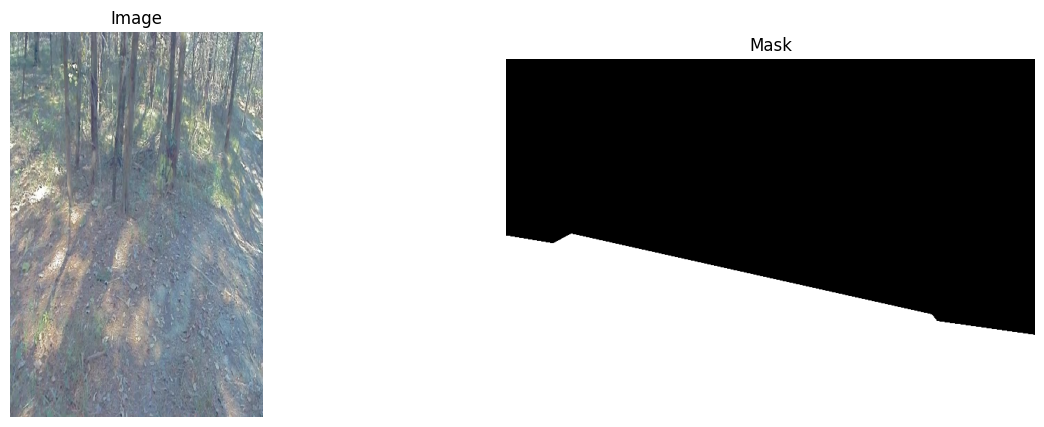

Image file path: /scratch/marque6/CaSSed_Dataset_Final/MAVS_Simulated_Data/imgs/image_1605.bmp
Mask file path: /scratch/marque6/CaSSed_Dataset_Final/MAVS_Simulated_Data/annos/annotated_1605.bmp
Dataset name: MAVS_Simulated_Data


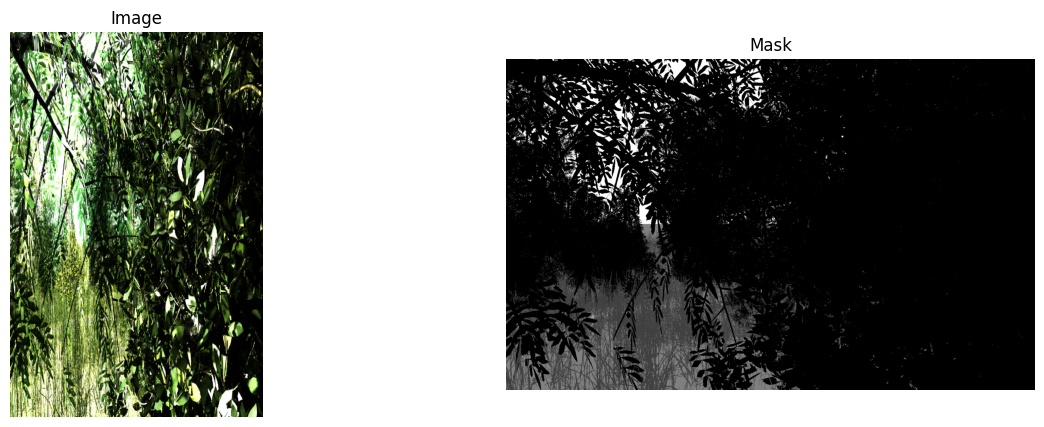

Image file path: /scratch/marque6/CaSSed_Dataset_Final/real_world_data/Dataset4_NorthSlope_Segmentation/Dataset1/raw_images/north_slope_video.mp4_26_1.jpg
Mask file path: /scratch/marque6/CaSSed_Dataset_Final/real_world_data/Dataset4_NorthSlope_Segmentation/Dataset1/annotations/north_slope_video.mp4_9_1.jpg
Dataset name: Dataset4_NorthSlope_Segmentation


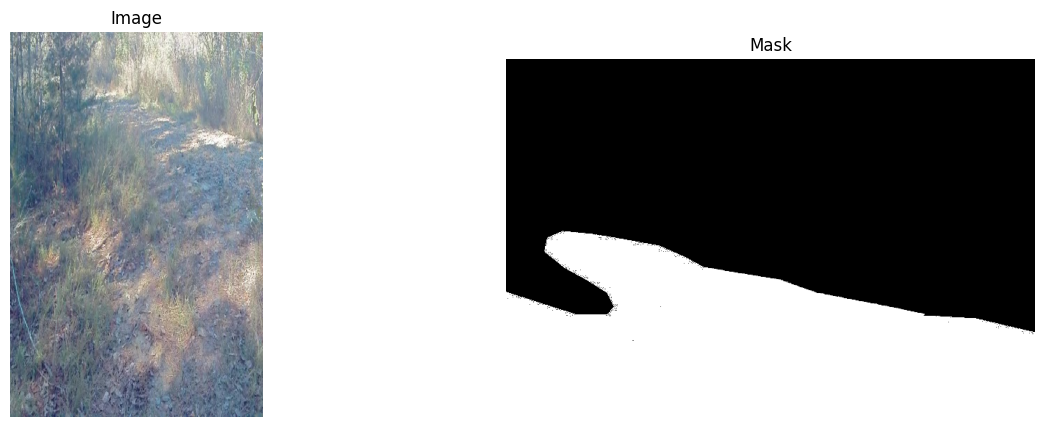

Image file path: /scratch/marque6/CaSSed_Dataset_Final/MAVS_Simulated_Data/imgs/image_1331.bmp
Mask file path: /scratch/marque6/CaSSed_Dataset_Final/MAVS_Simulated_Data/annos/annotated_1331.bmp
Dataset name: MAVS_Simulated_Data


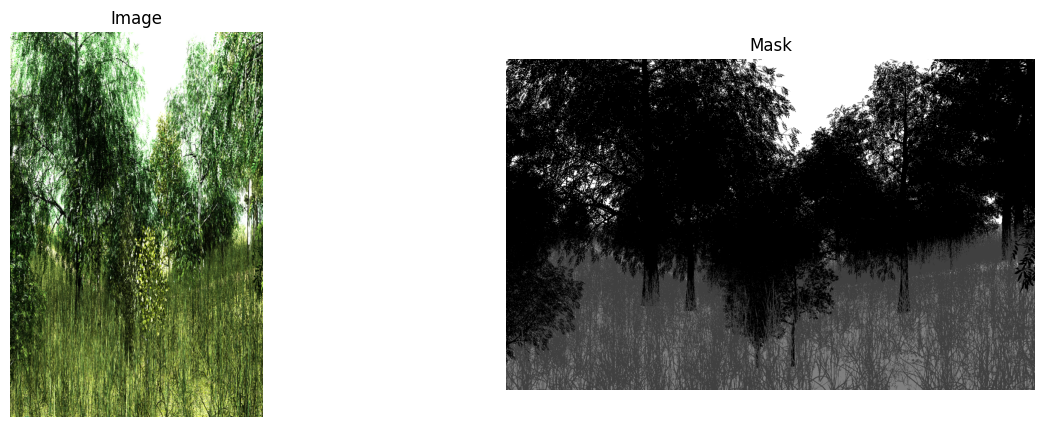

Image file path: /scratch/marque6/CaSSed_Dataset_Final/MAVS_Simulated_Data/imgs/image_0180.bmp
Mask file path: /scratch/marque6/CaSSed_Dataset_Final/MAVS_Simulated_Data/annos/annotated_0180.bmp
Dataset name: MAVS_Simulated_Data


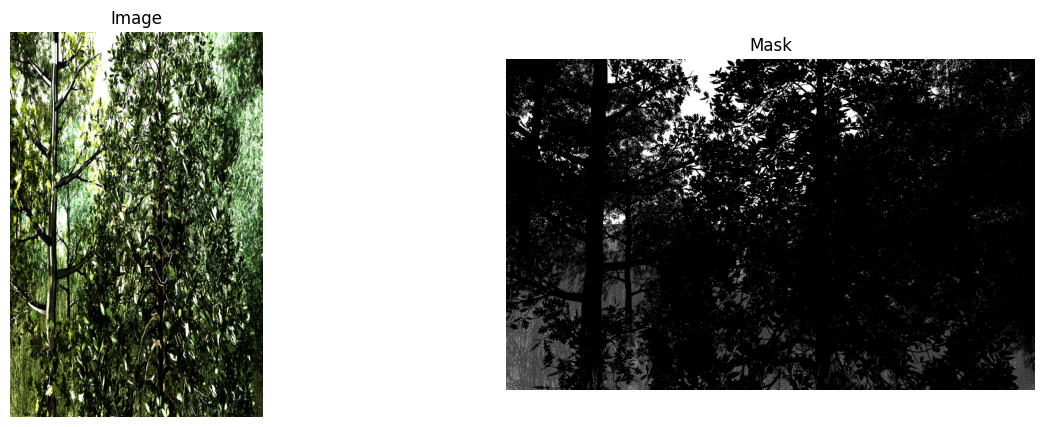

In [8]:
import matplotlib.pyplot as plt

def visualize_dataset(dataset, num_samples=5):
    for i in range(num_samples):
        sample = dataset[i]
        image = sample["data"].permute(1, 2, 0).numpy()  # Change the dimensions for matplotlib
        mask = sample["label"].numpy()
        
        img_mask_pair = dataset.image_mask_pairs[i]
        
        if len(img_mask_pair) == 3:
            img_path, mask_path, dataset_name = img_mask_pair
        else:
            print(f"Unexpected structure in image_mask_pairs at index {i}: {img_mask_pair}")
            continue
        
        print(f"Image file path: {img_path}")
        print(f"Mask file path: {mask_path}")
        print(f"Dataset name: {dataset_name}")

        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        ax[0].imshow(image)
        ax[0].set_title('Image')
        ax[0].axis('off')

        ax[1].imshow(mask, cmap='gray')
        ax[1].set_title('Mask')
        ax[1].axis('off')

        plt.show()

# Visualize samples from the training dataset
visualize_dataset(trainDS)

